# Оценка точности модели, переобучение, регуляризация

1. **Преобразуйте данные:**  
    a. проверьте наличие пропущенных значений. Преобразуйте/удалите пропуски по необходимости;  
    b. закодируйте категориальные переменные числовыми значениями по необходимости.  

In [1]:
import pandas as pd

# Загрузка данных
file_path = 'C:/Users/Yaros/Downloads/ноутбук_и_дополнительнае_материалы-_Оценка_точности_модели__переобучение__регуляризация/affair_data.csv'
data = pd.read_csv(file_path)

# Первичный осмотр данных
data.info(), data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rate_marriage    6366 non-null   float64
 1   age              6366 non-null   float64
 2   yrs_married      6366 non-null   float64
 3   children         6366 non-null   float64
 4   religious        6366 non-null   float64
 5   educ             6366 non-null   float64
 6   occupation       6366 non-null   float64
 7   occupation_husb  6366 non-null   float64
 8   affair           6366 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 447.7 KB


(None,
    rate_marriage   age  yrs_married  children  religious  educ  occupation  \
 0            3.0  32.0          9.0       3.0        3.0  17.0         2.0   
 1            3.0  27.0         13.0       3.0        1.0  14.0         3.0   
 2            4.0  22.0          2.5       0.0        1.0  16.0         3.0   
 3            4.0  37.0         16.5       4.0        3.0  16.0         5.0   
 4            5.0  27.0          9.0       1.0        1.0  14.0         3.0   
 
    occupation_husb  affair  
 0              5.0       1  
 1              4.0       1  
 2              5.0       1  
 3              5.0       1  
 4              4.0       1  )

In [2]:
# Проверка на наличие пропущенных значений
data.isnull().sum()

rate_marriage      0
age                0
yrs_married        0
children           0
religious          0
educ               0
occupation         0
occupation_husb    0
affair             0
dtype: int64

In [3]:
# Проверка уникальных значений для потенциально категориальных переменных
unique_values = {col: data[col].unique() for col in ['occupation', 'occupation_husb']}
unique_values

{'occupation': array([2., 3., 5., 4., 1., 6.]),
 'occupation_husb': array([5., 4., 3., 2., 6., 1.])}

*В данном случае никаких работ по подготовке данных не требуется.*  
*Переменные occupation и occupation_husb имеют дискретные числовые значения, что указывает на их категориальную природу - в связи с эти, решил оставить в таком виде и не преобразовывать в one-hot кодировку.*

2. **Разделите выборку на обучающее (80% данных) и тестовое (20% данных) подмножества.**

In [5]:
from sklearn.model_selection import train_test_split

# Определение признаков и целевой переменной
X = data.drop('affair', axis=1)
y = data['affair']

# Разделение данных на обучающую и тестовую выборки (80% и 20% соответственно)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Проверка размеров полученных выборок
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5092, 8), (1274, 8), (5092,), (1274,))

In [6]:
from sklearn.linear_model import LogisticRegression

# Обучение модели логистической регрессии
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

3. **Постройте ROC-кривую с помощью функции sklearn.metrics. roc_curve.**

In [11]:
from sklearn.metrics import roc_curve

# Получение вероятностей принадлежности к классу 1
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

fpr[:5], tpr[:5], thresholds[:5]

(array([0.        , 0.        , 0.        , 0.00117786, 0.00117786]),
 array([0.        , 0.00235294, 0.03058824, 0.03058824, 0.03294118]),
 array([       inf, 0.92376786, 0.86101849, 0.85930235, 0.85422667]))

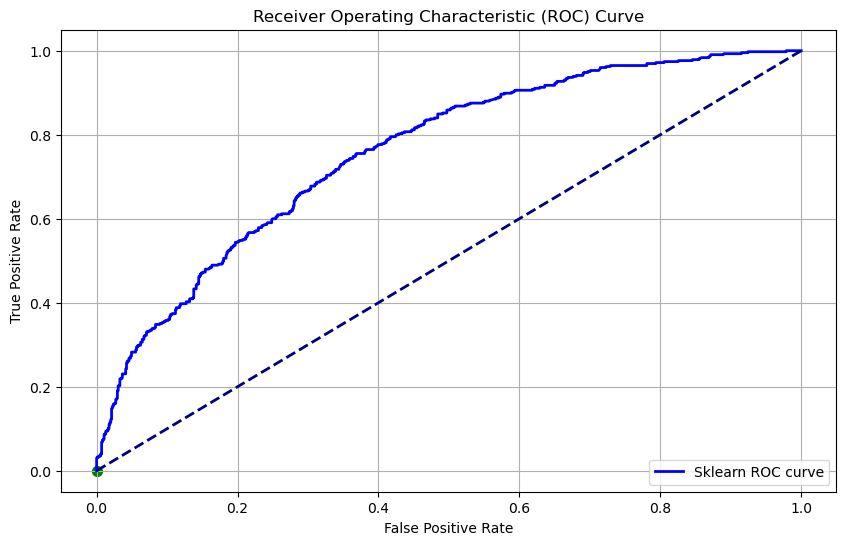

In [25]:
import matplotlib.pyplot as plt

# Построение ROC-кривой
plt.figure(figsize=(10, 6))

# ROC-кривая
plt.plot(fpr, tpr, color='blue', lw=2, label='Sklearn ROC curve')

# Добавление диагональной линии
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Настройка графика
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")


# Подсветка начальной точки кривой
plt.scatter([0], [0], color='green', s=50, label='Starting Point (0,0)')


# Отображение графика
plt.grid()
plt.show()

4. **Вычислите значение ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score.**

In [19]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, y_pred_prob)

roc_auc

0.7583856440102543

5. **Реализуйте подсчет метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn.**

In [28]:
import numpy as np

# Функция для расчета TPR и FPR
def calculate_tpr_fpr(y_true, y_pred_prob, thresholds):

    tpr = []
    fpr = []

    for thresh in thresholds:

        # Преобразование вероятностей в бинарные предсказания на основе текущего порога
        y_pred = (y_pred_prob >= thresh).astype(int)

        # Вычисление TP, FP, TN, FN
        TP = np.sum((y_true == 1) & (y_pred == 1))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        TN = np.sum((y_true == 0) & (y_pred == 0))
        FN = np.sum((y_true == 1) & (y_pred == 0))

        # Расчет TPR и FPR
        tpr.append(TP / (TP + FN) if (TP + FN) != 0 else 0)
        fpr.append(FP / (FP + TN) if (FP + TN) != 0 else 0)

    return np.array(fpr), np.array(tpr)

In [31]:
# Расчет TPR и FPR "вручную"
fpr_manual, tpr_manual = calculate_tpr_fpr(y_test, y_pred_prob, thresholds)

fpr_manual[:5], tpr_manual[:5]

(array([0.        , 0.        , 0.        , 0.00117786, 0.00117786]),
 array([0.        , 0.00235294, 0.03058824, 0.03058824, 0.03294118]))

6. **Постройте ROC-кривую с помощью вычисленных в п. 5 метрик: объедините графики из п. 3 и п. 6 в один. Сравните, сделайте вывод.**

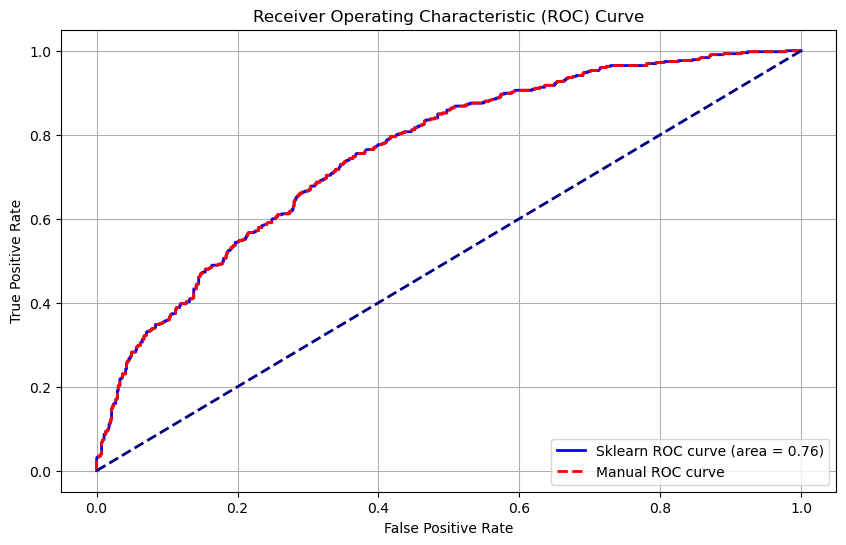

In [32]:
import matplotlib.pyplot as plt

# Построение ROC-кривых
plt.figure(figsize=(10, 6))

# Кривая, построенная с помощью функции sklearn
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Sklearn ROC curve (area = {roc_auc:.2f})')

# Кривая, построенная "вручную"
plt.plot(fpr_manual, tpr_manual, color='red', lw=2, linestyle='--', label='Manual ROC curve')

# Добавление диагональной линии
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Настройка графика
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Отображение графика
plt.grid()
plt.show()

7. **Постройте график Precision-Recall, используя метрики, посчитанные в п. 5.**

*Для этого, мне необходимо переопределить функцию из п.5*

In [39]:
# Переопределение функции с расчетом Precision в дополнение к TPR и FPR
def calculate_tpr_fpr_precision(y_true, y_pred_prob, thresholds):
    tpr = []  # True Positive Rate (Recall)
    fpr = []  # False Positive Rate
    precision = []  # Precision


    for thresh in thresholds:
        # Преобразование вероятностей в бинарные предсказания на основе текущего порога
        y_pred = (y_pred_prob >= thresh).astype(int)

        # Вычисление TP, FP, TN, FN
        TP = np.sum((y_true == 1) & (y_pred == 1))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        TN = np.sum((y_true == 0) & (y_pred == 0))
        FN = np.sum((y_true == 1) & (y_pred == 0))

        # Расчет TPR (Recall) и FPR
        TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) != 0 else 0

        # Расчет Precision
        Prec = TP / (TP + FP) if (TP + FP) != 0 else 0

        tpr.append(TPR)
        fpr.append(FPR)
        precision.append(Prec)

    return np.array(fpr), np.array(tpr), np.array(precision)


In [41]:
# Вычисление метрик
thresholds = np.linspace(0, 1, 100)
fpr, tpr, precision = calculate_tpr_fpr_precision(y_test, y_pred_prob, thresholds)

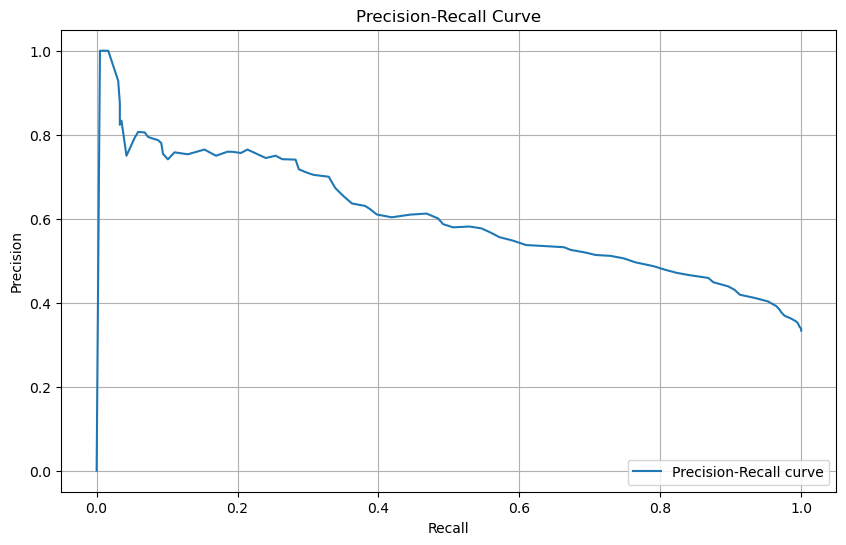

In [42]:
# Построение Precision-Recall кривой
plt.figure(figsize=(10, 6))

# Precision-Recall, используя метрики , посчитанные в п. 5.
plt.plot(tpr, precision, label='Precision-Recall curve')

# Настройка графика
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")

# Отображение графика
plt.grid()
plt.show()

8. ***Вычислите значение ROC-AUC метрики, используя метрики, посчитанные в п. 5.**

In [43]:
# Функция для вычисления AUC используя трапецеидальное правило
def calculate_auc(fpr, tpr):

    # Сортировка по FPR
    sorted_indices = np.argsort(fpr)
    fpr_sorted = fpr[sorted_indices]
    tpr_sorted = tpr[sorted_indices]

    # Вычисление площади под кривой ROC (AUC)
    auc = 0.0

    for i in range(len(fpr_sorted) - 1):
        delta_fpr = fpr_sorted[i+1] - fpr_sorted[i]
        avg_tpr = (tpr_sorted[i+1] + tpr_sorted[i]) / 2.0
        auc += delta_fpr * avg_tpr

    return auc

In [44]:
roc_auc_manual = calculate_auc(fpr, tpr)
roc_auc_manual

0.7583607011709276

*Значение ROC-AUC метрики, вычисленное вручную с использованием трапециевидного правила, составляет приблизительно 0.758. Это значение близко к тому, что мы получили, используя встроенную функцию roc_auc_score*

9. **Сформулируйте выводы по проделанной работе:**

- ROC-кривая и значение ROC-AUC (0.758) свидетельствуют о том, что модель имеет неплохое качество классификации, значительно превосходящее случайное угадывание.

In [46]:
pr_auc_manual = calculate_auc(tpr, precision)
pr_auc_manual

0.6051629426540633

In [50]:
from sklearn.metrics import precision_recall_curve, auc
precision2, recall2, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall2, precision2)
pr_auc

0.608191901807268

- PR-AUC в 0.605 можно считать умеренным результатом, который указывает на то, что модель имеет потенциал для дальнейшего улучшения

- В целом, модель кажется довольно надежной, однако есть простор для улучшения, особенно в области увеличения точности (precision) при высоком уровне полноты (recall).